**BUILDING A LANGUAGE TRANSLATION USING ENCODER-DECODER ARCHITECTURE and NEURAL MACHINE NETWORK**

In [1]:
# import the required libraries:
import os, sys
from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [2]:
#Execute this script to set values for different parameters:
BATCH_SIZE = 64
EPOCHS = 20
LSTM_NODES =256
NUM_SENTENCES = 20000
MAX_SENTENCE_LENGTH = 50
MAX_NUM_WORDS = 20000
EMBEDDING_SIZE = 200

The language translation model will translate English sentences into their French language counterparts. To develop such a model, we need a dataset that contains English sentences and their French translations.

# Data Preprocessing

We generate two copies of the translated sentence: one with the start-of-sentence token and the other with the end-of-sentence token.



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
input_sentences = []
output_sentences = []
output_sentences_inputs = []

count = 0
for line in open('/content/drive/MyDrive/Colab Notebooks/fra.txt', encoding="utf-8"):
    count += 1
    if count > NUM_SENTENCES:
        break
    if '\t' not in line:
        continue
    input_sentence = line.rstrip().split('\t')[0]
    output = line.rstrip().split('\t')[1]

    output_sentence = output + ' <eos>'
    output_sentence_input = '<sos> ' + output

    input_sentences.append(input_sentence)
    output_sentences.append(output_sentence)
    output_sentences_inputs.append(output_sentence_input)

print("Number of sample input:", len(input_sentences))
print("Number of sample output:", len(output_sentences))
print("Number of sample output input:", len(output_sentences_inputs))

Number of sample input: 20000
Number of sample output: 20000
Number of sample output input: 20000


In [5]:
print("English sentence: ",input_sentences[50])
print("French translation: ",output_sentences[50])

English sentence:  Hello!
French translation:  Bonjour ! <eos>


In [6]:
print("English sentence: ",input_sentences[180])
print("French translation: ",output_sentences[180])

English sentence:  Be fair.
French translation:  Soyez honnêtes. <eos>


# Tokenization and Padding


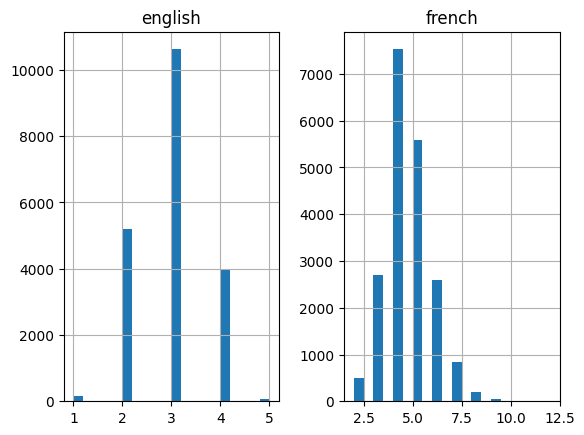

In [7]:
# let’s visualise the length of the sentences.
import pandas as pd

eng_len = []
fren_len = []

# populate the lists with sentence lengths
for i in input_sentences:
      eng_len.append(len(i.split()))

for i in output_sentences:
      fren_len.append(len(i.split()))

length_df = pd.DataFrame({'english':eng_len, 'french':fren_len})

length_df.hist(bins = 20)
plt.show()

The histogram above shows  maximum length of the French sentences is 12 and that of the English sentence is 6.

For tokenization, the Tokenizer class from the keras.preprocessing.text library can be used. The tokenizer class performs two tasks:

1. It divides a sentence into the corresponding list of word

2. Then it converts the words to integers



In [8]:
#tokenize the input sentences(input language)
input_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)
print(input_integer_seq)

word2idx_inputs = input_tokenizer.word_index
print('Total unique words in the input: %s' % len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Length of longest sentence in input: %g" % max_input_len)

#with open('input_tokenizer_NMT.pickle', 'wb') as handle:
#    pickle.dump(input_tokenizer, handle, protocol=4)

[[17], [17], [17], [17], [553], [553], [122], [122], [122], [122], [122], [122], [122], [122], [122], [122], [122], [122], [122], [122], [122], [122], [53], [1414], [1414], [1414], [1192], [1192], [1192], [598], [55], [700], [700], [641], [641], [52], [52], [52], [104], [104], [104], [104], [104], [104], [104], [757], [757], [17, 43], [17, 43], [17, 43], [407], [407], [407], [407], [407], [407], [1, 68], [1, 68], [1, 79], [1, 171], [1, 171], [1, 171], [832, 32], [381], [381], [381], [381], [381], [381], [381], [381], [381], [381], [381], [381], [554], [554], [554], [257], [599], [599], [599], [599], [191, 4], [191, 4], [191, 4], [191, 4], [1193], [1193], [1193], [1193], [113, 4], [113, 4], [1194], [28, 30], [28, 30], [28, 30], [17, 63], [17, 63], [17, 63], [50, 4], [50, 4], [50, 4], [50, 4], [50, 4], [50, 4], [1723, 36], [1723, 36], [491, 8], [491, 8], [1, 306], [1, 306], [1, 2363], [1, 1724], [1, 2364], [1, 80], [1, 145], [1, 145], [1, 361], [1, 78], [1, 408], [1, 408], [1, 408], [1, 

In [9]:
#tokenize the output sentences(Output language)
output_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
output_tokenizer.fit_on_texts(output_sentences + output_sentences_inputs)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)
print(output_input_integer_seq)

word2idx_outputs = output_tokenizer.word_index
print('Total unique words in the output: %s' % len(word2idx_outputs))

num_words_output = len(word2idx_outputs) + 1
max_out_len = max(len(sen) for sen in output_integer_seq)
print("Length of longest sentence in the output: %g" % max_out_len)

#with open('output_tokenizer_NMT.pickle', 'wb') as handle:
#    pickle.dump(output_tokenizer, handle, protocol=4)

[[2, 47, 4], [2, 547], [2, 24, 449, 4], [2, 422, 4], [2, 673, 4], [2, 2663], [2, 2664], [2, 2665], [2, 116, 240, 1177, 22, 240, 1916, 4], [2, 1471, 4], [2, 1917, 4], [2, 674, 4], [2, 2666, 4], [2, 2667, 4], [2, 2664], [2, 2665], [2, 116, 240, 1177, 22, 240, 1916, 4], [2, 1471, 4], [2, 1917, 4], [2, 674, 4], [2, 2666, 4], [2, 2667, 4], [2, 32, 6], [2, 27, 4469], [2, 4470], [2, 4471], [2, 22, 4472], [2, 4473], [2, 4474], [2, 65, 754, 4], [2, 22, 2668], [2, 4475], [2, 4476], [2, 1918], [2, 1918], [2, 27, 2669], [2, 4477], [2, 1472, 4], [2, 298, 4], [2, 357, 4], [2, 1178], [2, 298, 4], [2, 357, 4], [2, 4478], [2, 1178], [2, 1919], [2, 1920], [2, 4479], [2, 4480], [2, 4481], [2, 866, 4], [2, 673, 4], [2, 866, 4], [2, 673, 4], [2, 675], [2, 2663], [2, 3, 1473], [2, 4482], [2, 2670], [2, 17, 385, 4], [2, 3, 75, 1008, 4], [2, 125, 340], [2, 4483, 507, 4], [2, 1179], [2, 1921], [2, 1922], [2, 2671, 2672], [2, 2673, 2674], [2, 44, 1474], [2, 1923, 4], [2, 1180, 4], [2, 2675], [2, 1181, 4], [2, 4

In [10]:
encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences.shape:", encoder_input_sequences.shape)
print("encoder_input_sequences[180]:", encoder_input_sequences[180])

encoder_input_sequences.shape: (20000, 5)
encoder_input_sequences[180]: [  0   0   0  22 313]


In [11]:
print(word2idx_inputs["join"])
print(word2idx_inputs["us"])

493
57


In the same way, the decoder outputs and the decoder inputs are padded.



In [12]:
decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences.shape:", decoder_input_sequences.shape)
print("decoder_input_sequences[180]:", decoder_input_sequences[180])

decoder_input_sequences.shape: (20000, 12)
decoder_input_sequences[180]: [   2   52 1934    0    0    0    0    0    0    0    0    0]


In [13]:
print(word2idx_outputs["<sos>"])
print(word2idx_outputs["joignez-vous"])
print(word2idx_outputs["à"])
print(word2idx_outputs["nous."])

2
2705
22
231


In [14]:
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_output_sequences.shape:", decoder_output_sequences.shape)


decoder_output_sequences.shape: (20000, 12)


# Word Embeddings


In [15]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open(r'/content/drive/MyDrive/Colab Notebooks/glove.twitter.27B.200d.txt', encoding="utf8")

for line in glove_file:
    rec = line.split()
    word = rec[0]
    vector_dimensions = asarray(rec[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

In [16]:
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
embedding_matrix = zeros((num_words, EMBEDDING_SIZE))
for word, index in word2idx_inputs.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector


ValueError: ignored

In [24]:
print(embedding_matrix[464])

[ 1.85010001e-01  4.32799995e-01 -5.30399978e-01  2.59810001e-01
 -1.12740003e-01 -3.62370014e-01  4.50700015e-01  7.83970021e-03
 -4.95380014e-01 -3.54140013e-01 -4.95969988e-02  2.14159995e-01
 -1.13399994e+00 -2.40349993e-01 -8.24609958e-03  1.28309995e-01
  4.88820001e-02  3.68710011e-01 -7.50209987e-01 -3.50079983e-02
  6.30869985e-01  2.21379995e-01  2.32899994e-01 -1.89250000e-02
 -2.16069996e-01  1.43680000e+00  3.60569991e-02 -1.28659993e-01
 -4.49450016e-02  2.05599993e-01 -3.31869990e-01  7.98560008e-02
 -3.19530010e-01 -1.67469997e-02  2.50730008e-01 -1.02770001e-01
 -2.19980001e-01 -6.26720011e-01 -1.49949998e-01 -3.12849998e-01
  6.68550014e-01  1.35829998e-02  8.51290002e-02 -8.32910016e-02
  1.89679995e-01 -6.36179984e-01  6.18780017e-01 -4.94129986e-01
 -1.79560006e-01  2.94349998e-01 -1.59390002e-01 -2.52429992e-01
 -1.02449998e-01 -4.40129995e-01  9.90350023e-02  2.85569996e-01
 -7.15960026e-01  6.51850030e-02 -6.75159991e-02 -2.28310004e-01
 -9.39029992e-01  2.89310

**Creates the embedding layer for the input:**

In [25]:
embedding_layer = Embedding(num_words, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=max_input_len)


# Creating the Model



In [18]:
#(number of inputs, length of the output sentence, the number of words in the output)

In [19]:
decoder_targets_one_hot = np.zeros((
        len(input_sentences),
        max_out_len,
        num_words_output
    ),
    dtype='float32'
)
decoder_targets_one_hot.shape

(20000, 12, 9428)

In [20]:
for i, d in enumerate(decoder_output_sequences):
    for t, word in enumerate(d):
        decoder_targets_one_hot[i, t, word] = 1

In [26]:
encoder_inputs = Input(shape=(max_input_len,))
x = embedding_layer(encoder_inputs)
encoder = LSTM(LSTM_NODES, return_state=True)

encoder_outputs, h, c = encoder(x)
encoder_states = [h, c]

In [27]:
decoder_inputs = Input(shape=(max_out_len,))

decoder_embedding = Embedding(num_words_output, LSTM_NODES)
decoder_inputs_x = decoder_embedding(decoder_inputs)

decoder_lstm = LSTM(LSTM_NODES, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

In [28]:
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [29]:
#Compile
model = Model([encoder_inputs,decoder_inputs], decoder_outputs)
model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 5)]                  0         []                            
                                                                                                  
 input_5 (InputLayer)        [(None, 12)]                 0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 5, 200)               668600    ['input_4[0][0]']             
                                                                                                  
 embedding_2 (Embedding)     (None, 12, 256)              2413568   ['input_5[0][0]']             
                                                                                              

In [30]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [ ]:

#history=model.fit([encoder_input_sequences, decoder_input_sequences], decoder_targets_one_hot, batch_size=8, epochs=5, callbacks=[es], validation_split=0.1)

Plotting the model :->

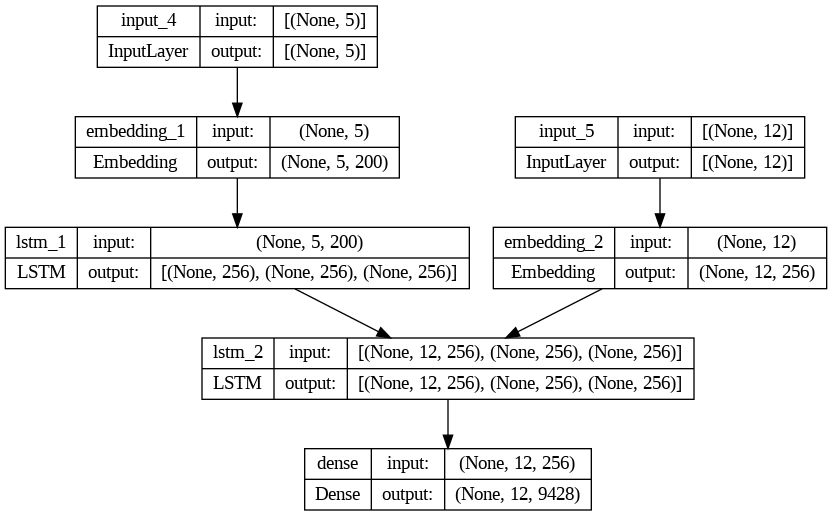

In [31]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

history = model.fit([encoder_input_sequences, decoder_input_sequences], decoder_targets_one_hot,
    batch_size=BATCH_SIZE,
    epochs=20,
    callbacks=[es],
    validation_split=0.1,
)


In [32]:
model.save('seq2seq_eng-fra.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import matplotlib.pyplot as plt
# %matplotlib inline
plt.title('Model Loss')
#plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [33]:
encoder_model = Model(encoder_inputs, encoder_states)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.load_weights('seq2seq_eng-fra.h5')

In [34]:
decoder_state_input_h = Input(shape=(LSTM_NODES,))
decoder_state_input_c = Input(shape=(LSTM_NODES,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

In [35]:
decoder_outputs, h, c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)


In [36]:
decoder_states = [h, c]
decoder_outputs = decoder_dense(decoder_outputs)

In [37]:
decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)

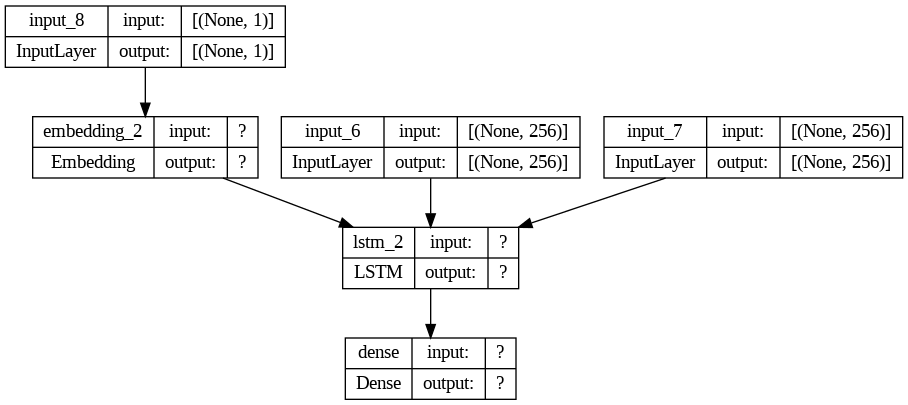

In [38]:
from keras.utils import plot_model
plot_model(decoder_model, to_file='model_plot_dec.png', show_shapes=True, show_layer_names=True)

# Making Predictions


In [39]:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [40]:
def translate_sentence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']
    eos = word2idx_outputs['<eos>']
    output_sentence = []

    for _ in range(max_out_len):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        if eos == idx:
            break

        word = ''

        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        target_seq[0, 0] = idx
        states_value = [h, c]

    return ' '.join(output_sentence)

In [41]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
translation = translate_sentence(input_seq)
print('Input Language : ', input_sentences[i])

print('French translation : ', translation)

1/1 [==============================] - 0s 22ms/step
Input Language :  Just be happy.
French translation :  Sois tout simplement heureuse. <eos>


In [42]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
translation = translate_sentence(input_seq)
print('Input Language : ', input_sentences[i])

print('French translation : ', translation)

1/1 [==============================] - 0s 34ms/step
Input Language :  You're arrogant.
French translation :  Vous êtes arrogante. <eos>


In [43]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
translation = translate_sentence(input_seq)
print('Input Language : ', input_sentences[i])

print('French translation : ', translation)

1/1 [==============================] - 0s 20ms/step
Input Language :  I serve no one.
French translation :  Je ne suis au service de personne. <eos>


In [44]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
translation = translate_sentence(input_seq)
print('Input Language : ', input_sentences[i])

print('French translation : ', translation)

1/1 [==============================] - 0s 28ms/step
Input Language :  Are you sure?
French translation :  Êtes-vous sûrs ? <eos>


In [45]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
translation = translate_sentence(input_seq)
print('Input Language : ', input_sentences[i])

print('French translation : ', translation)

1/1 [==============================] - 0s 24ms/step
Input Language :  Don't play dumb!
French translation :  Ne fais pas l'imbécile. <eos>


In [46]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
translation = translate_sentence(input_seq)
print('Input Language : ', input_sentences[i])

print('French translation : ', translation)

1/1 [==============================] - 0s 32ms/step
Input Language :  Why blame Tom?
French translation :  Pourquoi accuser Tom ? <eos>


In [47]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
translation = translate_sentence(input_seq)
print('Input Language : ', input_sentences[i])

print('French translation : ',translation)

1/1 [==============================] - 0s 28ms/step
Input Language :  It will work.
French translation :  Cela fonctionnera. <eos>


In [49]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
translation = translate_sentence(input_seq)
print('Input Language : ', input_sentences[i])

print('French translation : ',translation)

1/1 [==============================] - 0s 30ms/step
Input Language :  Just take one.
French translation :  N'en prends qu'une. <eos>


In [ ]:

names = ["Alice Go"]

# "Alice go", "Bob come"]
#tokenize the input sentences(input language)

input_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
input_tokenizer.fit_on_texts(names)
input_integer_seq = input_tokenizer.texts_to_sequences(names)
print(input_integer_seq)

word2idx_inputs = input_tokenizer.word_index
print('Total unique words in the input: %s' % len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Length of longest sentence in input: %g" % max_input_len)


In [ ]:
encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=8)

In [ ]:
names = ["Alice Go"]

# "Alice go", "Bob come"]
#tokenize the input sentences(input language)

input_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
input_tokenizer.fit_on_texts(names)
input_integer_seq = input_tokenizer.texts_to_sequences(names)
print(input_integer_seq)

word2idx_inputs = input_tokenizer.word_index
print('Total unique words in the input: %s' % len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Length of longest sentence in input: %g" % max_input_len)

In [ ]:


#with open('input_tokenizer_NMT.pickle', 'wb') as handle:
#    pickle.dump(input_tokenizer, handle, protocol=4)

i=0
input_seq = encoder_input_sequences[i:i+1]
translation = translate_sentence(input_seq)
print('Input Language : ', input_sentences[i])
print('Actual translation : ', output_sentences[i])
print('French translation : ', translation)

In [ ]:
!pip install transformers ipywidgets gradio --upgrade

In [ ]:
import gradio as gr

In [ ]:
input_sentences2 = []
output_sentences = []
output_sentences_inputs = []

count = 0
for line in open('/content/drive/MyDrive/Colab Notebooks/alltexts.txt', encoding="utf-8"):
    count += 1
    if count > NUM_SENTENCES:
        break
    if '\t' not in line:
        continue
    input_sentence2 = line.rstrip().split('\t')[0]
    output = line.rstrip().split('\t')[1]

    output_sentence = output + ' <eos>'
    output_sentence_input = '<sos> ' + output

    input_sentences2.append(input_sentence2)

In [ ]:
i = 1
input_seq = encoder_input_sequences[i:i+1]
translation = translate_sentence(input_seq)
print('Input Language : ',)
#print('Actual translation : ', output_sentences[i])
print('French translation : ', translation)

In [ ]:
####creating streamlit web application

In [ ]:
# importing the libraries
import streamlit as st
import os
import openai
from secret_key import openapi_key
# Enter your openAI key here
#os.environ['OPENAI_API_KEY'] = openapi_key

# Define the list of available languages
languages = [
    "English",
    "Hindi",
    "French",
    "Telugu",
    "Albanian",
    "Bengali",
    "Bhojpuri",
    # Add more languages as needed, if you want
    ]

# creating a function.

def translate_text(text, source_language, target_language):
    response = openai.Completion.create(
        engine='text-davinci-002',
        prompt="Translate the following text from {source_language}to {target_language}:\n{text}",
        max_tokens=100,
        n=1,
        stop=None,
        temperature=0,
        top_p=1.0,
        frequency_penalty=0.0,
        presence_penalty=0.0
    )

    translation = response.choices[0].text.strip().split("\n")[0]
    return translation

# Streamlit web app
def main():
    st.title("Translate My Text")

    # Input text
    text = st.text_area("Enter the text to translate")

    # Source language dropdown to select the languages
    source_language = st.selectbox("Select source language", languages)

    # Target language dropdown to select the languages
    target_language = st.selectbox("Select target language", languages)

    # Translate button to translate
    if st.button("Translate"):
        translation = translate_text(text, source_language, target_language)
        st.markdown('<p style="color: blue; font-size: 25px;">{translation}</p>', unsafe_allow_html=True)

if __name__ == '__main__':
    main()